In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from utils.carbon import calculate_total_carbon
from utils.cost import calculate_total_cost

# Preprocess Data

In [ ]:
# INPUTS
TIME_HORIZONS= [2020, 2050,2100]

def get_csv_file_path(time_horizon: int) -> str:
    file_name =f"{time_horizon}_merged_simulation_results.csv"
    return f"inputs/{file_name}"

In [3]:
# COLUMN LABELS
TIME_HORIZON_LABEL = "time_horizon"
SIMULATION_ID = "simulation_id"
WINDOWS_U_FACTOR = 'windows_U_Factor'
GROUND_FLOOR_THERMAL_RESISTANCE = "groundfloor_thermal_resistance"
EXT_WALLS_THERMAL_RESISTANCE = "ext_walls_thermal_resistance"
ROOF_THERMAL_RESISTANCE= "roof_thermal_resistance"
ANNUAL_ENERGY_CONSUMPTION = "annual_energy_consumption"
TOTAL_COST = "total_cost"
TOTAL_CARBON_EMISSION = "total_carbon_emission"
COMFORT_DAYS = "comfort_days"

ELECTRICITY_BUILDING = "Electricity:Building"
ELECTRICITY_FACILITY = "Electricity:Facility"
GAS_CONSUMPTION = "Gas Consumption"
INDOOR_TEMPERATURE = "Zone Mean Air Temperature"

In [4]:

# Initialize the dataframe with the inputs
df_inputs = pd.DataFrame()
df_inputs = pd.DataFrame(columns=[SIMULATION_ID, TIME_HORIZON_LABEL, WINDOWS_U_FACTOR, GROUND_FLOOR_THERMAL_RESISTANCE, EXT_WALLS_THERMAL_RESISTANCE, ROOF_THERMAL_RESISTANCE])

# Initialize the dataframe with the outputs
df_outputs = pd.DataFrame()
df_outputs = pd.DataFrame(columns=[SIMULATION_ID, ANNUAL_ENERGY_CONSUMPTION, TOTAL_COST, TOTAL_CARBON_EMISSION, COMFORT_DAYS])

for time_horizon in TIME_HORIZONS:
    df = pd.read_csv(get_csv_file_path(time_horizon=time_horizon))

    date_columns = [col for col in df.columns if col.startswith(f"{str(time_horizon)}-")]

    for simulation_id, group in df.groupby('Simulation ID'):

        # Inputs
        df_inputs = pd.concat([df_inputs,
            pd.DataFrame({
                SIMULATION_ID: [int(simulation_id)],
                TIME_HORIZON_LABEL: [time_horizon],
                WINDOWS_U_FACTOR : [group[WINDOWS_U_FACTOR].iloc[0]],
                GROUND_FLOOR_THERMAL_RESISTANCE:[group[GROUND_FLOOR_THERMAL_RESISTANCE].iloc[0]],
                EXT_WALLS_THERMAL_RESISTANCE:[group[EXT_WALLS_THERMAL_RESISTANCE].iloc[0]],
                ROOF_THERMAL_RESISTANCE: [group[ROOF_THERMAL_RESISTANCE].iloc[0]]
            })], ignore_index=True
        )



        # Extract values
        electricity_building = group[group['index'].str.contains(ELECTRICITY_BUILDING)].iloc[0]
        electricity_facility = group[group['index'].str.contains(ELECTRICITY_FACILITY)].iloc[0] 
        gas_consumption = group[group['index'].str.contains(GAS_CONSUMPTION)].iloc[0] 
        indoor_temperature=group[group['index'].str.contains(INDOOR_TEMPERATURE)].iloc[0]


        annual_energy_consumption = (electricity_building[date_columns].sum() + 
                                electricity_facility[date_columns].sum() + 
                                gas_consumption[date_columns].sum())/10**9
        

        window_U_factor= group[WINDOWS_U_FACTOR].iloc[0]
        groundfloor_thermal_resistance=group[GROUND_FLOOR_THERMAL_RESISTANCE].iloc[0]
        ext_walls_thermal_resistance=group[EXT_WALLS_THERMAL_RESISTANCE].iloc[0]
        roof_thermal_resistance=group[ROOF_THERMAL_RESISTANCE].iloc[0]

        total_cost = calculate_total_cost(
            window_U_Factor=window_U_factor, 
            groundfloor_thermal_resistance=groundfloor_thermal_resistance,
            ext_walls_thermal_resistance=ext_walls_thermal_resistance, 
            roof_thermal_resistance=roof_thermal_resistance
            )
        
        comfort_days = min(len([item for item in indoor_temperature[date_columns].values if 18<item<24]),365)
        
        total_carbon_emission = calculate_total_carbon(        
            window_U_Factor=window_U_factor, 
            groundfloor_thermal_resistance=groundfloor_thermal_resistance,
            ext_walls_thermal_resistance=ext_walls_thermal_resistance, 
            roof_thermal_resistance=roof_thermal_resistance
            )
        

        df_outputs = pd.concat([df_outputs,
            pd.DataFrame({
                SIMULATION_ID: [int(simulation_id)],
                ANNUAL_ENERGY_CONSUMPTION : [annual_energy_consumption],
                TOTAL_COST: [total_cost],
                TOTAL_CARBON_EMISSION: [total_carbon_emission],
                COMFORT_DAYS: [comfort_days]
            })], ignore_index=True
        )

/var/folders/76/c14d3r6j5w310ybq_1tgcc0r0000gn/T/ipykernel_58645/724891861.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_inputs = pd.concat([df_inputs,
/var/folders/76/c14d3r6j5w310ybq_1tgcc0r0000gn/T/ipykernel_58645/724891861.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_outputs = pd.concat([df_outputs,


In [5]:
df_outputs

,simulation_id,annual_energy_consumption,total_cost,total_carbon_emission,comfort_days
0,1,4814.452339,0,0,233
1,2,4612.654118,182,9.36,246
2,3,4616.508510,179,4.83,248
3,4,4597.365174,200,17.16,244
4,5,4608.445220,222,8.5,244
...,...,...,...,...,...
1244,621,3987.337647,869,137.68,266
1245,622,3817.044451,1051,147.04,278
1246,623,3806.772476,1048,142.51,276
1247,624,3786.355399,1069,154.84,278


# Load and Preprocess data


In [6]:
X_data = df_inputs[[TIME_HORIZON_LABEL, WINDOWS_U_FACTOR, GROUND_FLOOR_THERMAL_RESISTANCE, EXT_WALLS_THERMAL_RESISTANCE, ROOF_THERMAL_RESISTANCE]].values
Y_data = df_outputs[[ANNUAL_ENERGY_CONSUMPTION, TOTAL_COST, TOTAL_CARBON_EMISSION, COMFORT_DAYS]].values
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
# Normalize the data 
X_data_normalized = scaler_X.fit_transform(X_data)
Y_data_normalized = scaler_Y.fit_transform(Y_data)

# Y_ORIGINAL = scaler_Y.inverse_transform(Y_data_normalized)


# Split the dataset into training, testing and validation sets
# Split data into train, validation, and test sets
# Training Set: 70% of the original data.
# Validation Set: 15% of the original data (from the temporary set).
# Test Set: 15% of the original data (from the temporary set).

train_inputs, temp_inputs, train_outputs, temp_outputs = train_test_split(
    X_data_normalized, Y_data_normalized, test_size=0.3, random_state=42
)
val_inputs, test_inputs, val_outputs, test_outputs = train_test_split(
    temp_inputs, temp_outputs, test_size=0.5, random_state=42
)

# Convert to torch tensors
train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
train_outputs = torch.tensor(train_outputs, dtype=torch.float32)
val_inputs = torch.tensor(val_inputs, dtype=torch.float32)
val_outputs = torch.tensor(val_outputs, dtype=torch.float32)
test_inputs = torch.tensor(test_inputs, dtype=torch.float32)
test_outputs = torch.tensor(test_outputs, dtype=torch.float32)

Epoch [10/200], Training Loss: 3.2113, Validation Loss: 3.1463
Epoch [20/200], Training Loss: 2.3171, Validation Loss: 2.2292
Epoch [30/200], Training Loss: 1.7641, Validation Loss: 1.7182
Epoch [40/200], Training Loss: 1.6582, Validation Loss: 1.6262
Epoch [50/200], Training Loss: 1.5286, Validation Loss: 1.4810
Epoch [60/200], Training Loss: 1.4504, Validation Loss: 1.3889
Epoch [70/200], Training Loss: 1.3830, Validation Loss: 1.3206
Epoch [80/200], Training Loss: 1.3376, Validation Loss: 1.2783
Epoch [90/200], Training Loss: 1.3054, Validation Loss: 1.2477
Epoch [100/200], Training Loss: 1.2823, Validation Loss: 1.2266
Epoch [110/200], Training Loss: 1.2639, Validation Loss: 1.2112
Epoch [120/200], Training Loss: 1.2487, Validation Loss: 1.1963
Epoch [130/200], Training Loss: 1.2349, Validation Loss: 1.1851
Epoch [140/200], Training Loss: 1.2209, Validation Loss: 1.1758
Epoch [150/200], Training Loss: 1.2078, Validation Loss: 1.1670
Epoch [160/200], Training Loss: 1.1953, Validatio

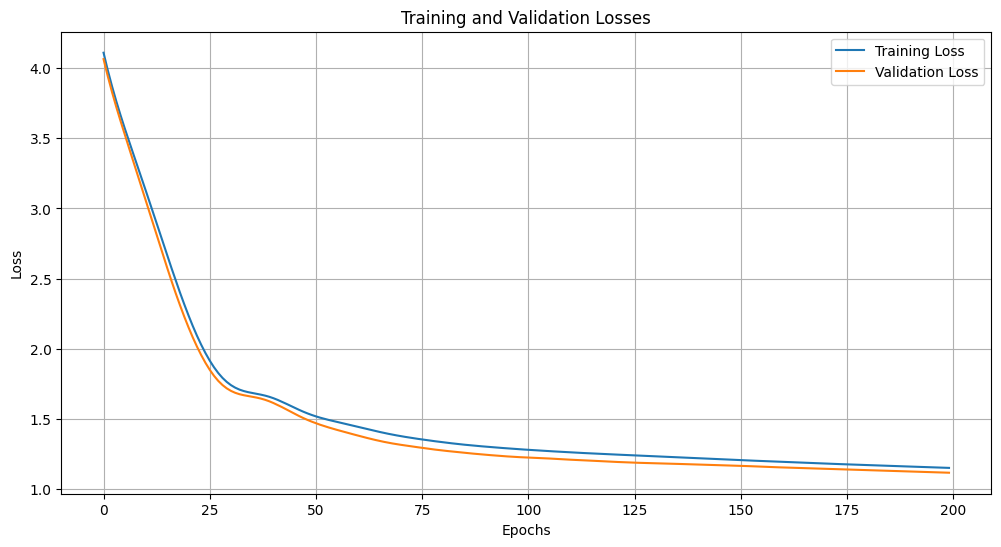

In [7]:
class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        self.fc1 = nn.Linear(5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3_energy = nn.Linear(64, 1)  # Annual Energy Consumption
        self.fc3_cost = nn.Linear(64, 1)    # Total Cost
        self.fc3_emission = nn.Linear(64, 1) # Total Carbon Emission
        self.fc3_comfort = nn.Linear(64, 1)  # Comfort Days

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        energy = self.fc3_energy(x)
        cost = self.fc3_cost(x)
        emission = self.fc3_emission(x)
        comfort = self.fc3_comfort(x)
        return energy, cost, emission, comfort

# Instantiate the model, define the loss function and the optimizer
model = MultiTaskModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 200
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(train_inputs)
    loss = sum(criterion(outputs[i], train_outputs[:, i:i+1]) for i in range(4))  # Total loss for all tasks
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs_pred = model(val_inputs)
        val_loss = sum(criterion(val_outputs_pred[i], val_outputs[:, i:i+1]) for i in range(4))
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()



In [8]:
# Testing the model
model.eval()
with torch.no_grad():
    test_outputs_pred = model(test_inputs)

# Inverse transform to get original scale
Y_test_inverse = scaler_Y.inverse_transform(test_outputs.numpy())
Y_test_pred_inverse = scaler_Y.inverse_transform(torch.cat(test_outputs_pred, dim=1).numpy())

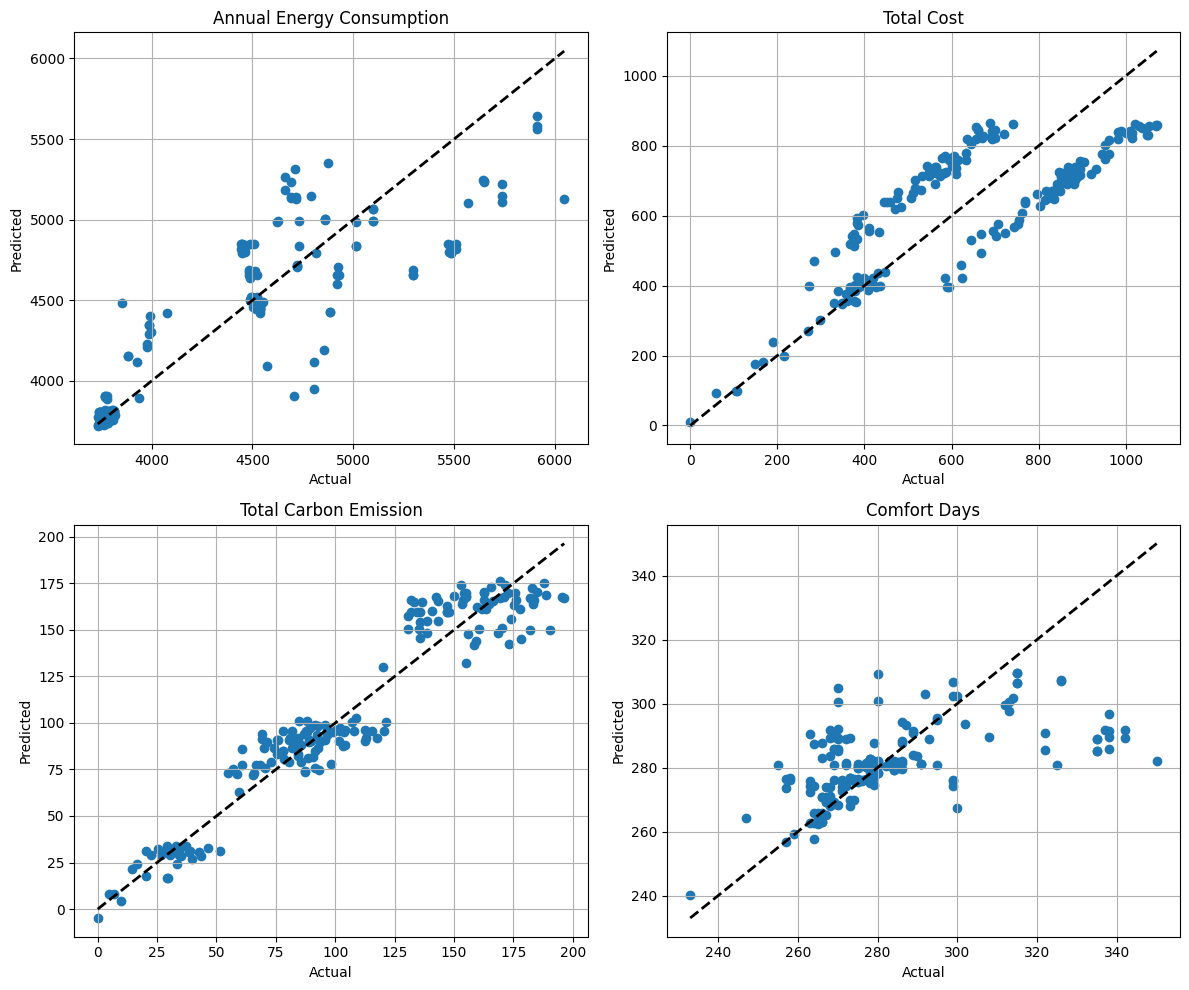

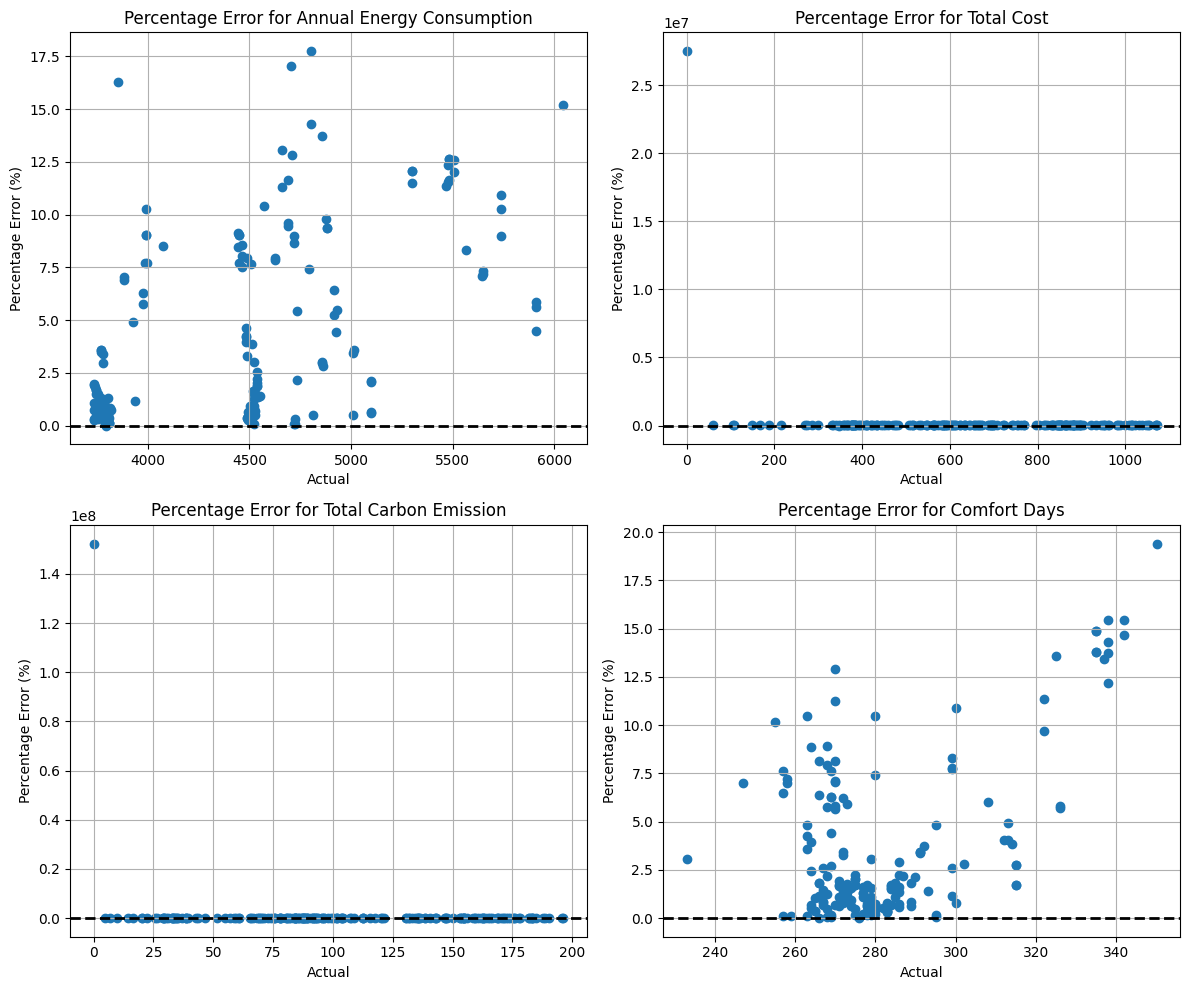

In [9]:
# Calculate percentage error
percentage_error = np.abs((Y_test_pred_inverse - Y_test_inverse) / Y_test_inverse) * 100

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Define labels for outputs
outputs_labels = ['Annual Energy Consumption', 'Total Cost', 'Total Carbon Emission', 'Comfort Days']

# Predicted vs Actual scatter plots
for i in range(4):
    axs[i // 2, i % 2].scatter(Y_test_inverse[:, i], Y_test_pred_inverse[:, i])
    axs[i // 2, i % 2].plot([Y_test_inverse[:, i].min(), Y_test_inverse[:, i].max()],
                             [Y_test_inverse[:, i].min(), Y_test_inverse[:, i].max()], 'k--', lw=2)
    axs[i // 2, i % 2].set_title(outputs_labels[i])
    axs[i // 2, i % 2].set_xlabel('Actual')
    axs[i // 2, i % 2].set_ylabel('Predicted')
    axs[i // 2, i % 2].grid()

plt.tight_layout()
plt.show()

# Plotting percentage error
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i in range(4):
    axs[i // 2, i % 2].scatter(Y_test_inverse[:, i], percentage_error[:, i])
    axs[i // 2, i % 2].axhline(y=0, color='k', linestyle='--', lw=2)  # Line for 0% error
    axs[i // 2, i % 2].set_title(f'Percentage Error for {outputs_labels[i]}')
    axs[i // 2, i % 2].set_xlabel('Actual')
    axs[i // 2, i % 2].set_ylabel('Percentage Error (%)')
    axs[i // 2, i % 2].grid()

plt.tight_layout()
plt.show()

In [10]:
percentage_error

array([[1.14059997e+00, 2.29840546e+01, 4.98303080e+00, 4.81917048e+00],
       [2.53592515e+00, 2.79322529e+01, 1.14901295e+01, 3.76114756e-01],
       [7.83845329e+00, 2.28514099e+01, 9.43405724e+00, 8.87302113e+00],
       [9.35478020e+00, 1.79614754e+01, 5.72726393e+00, 5.83104801e+00],
       [4.74652708e-01, 8.48627186e+00, 5.27850380e+01, 7.54232347e-01],
       [3.43526006e-01, 1.60941625e+00, 2.62747879e+01, 6.56694710e-01],
       [3.01856709e+00, 2.06999340e+01, 1.73924465e+01, 4.81511891e-01],
       [9.42786157e-01, 1.76041908e+01, 4.32841635e+00, 6.65237486e-01],
       [1.14480522e-03, 1.64903831e+01, 1.54040918e+01, 6.76899195e-01],
       [7.71476650e+00, 2.06162949e+01, 1.38871803e+01, 5.77597523e+00],
       [4.86211807e-01, 2.90917187e+01, 9.33475304e+00, 3.64860713e-01],
       [1.16496305e+01, 3.62341957e+01, 1.75160637e+01, 1.37904377e+01],
       [3.93738413e+00, 1.83631325e+01, 4.16132355e+00, 4.22693968e+00],
       [1.02507744e+01, 1.69510918e+01, 5.70641184e